# Applying variational inference on HD Gaussian process
prepared by Moses Chan, October 6 2022

In [1]:
import os
import sys
print('making sure I know where I am..', os.getcwd())
sys.path.insert(0, r'./tests/')

import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex', 'grid'])

import torch
import numpy as np

from func2d import forrester2008

making sure I know where I am.. C:\Users\moses\Desktop\git\binary-hd-emulator\code\gpVIIP


## Say we are given some data

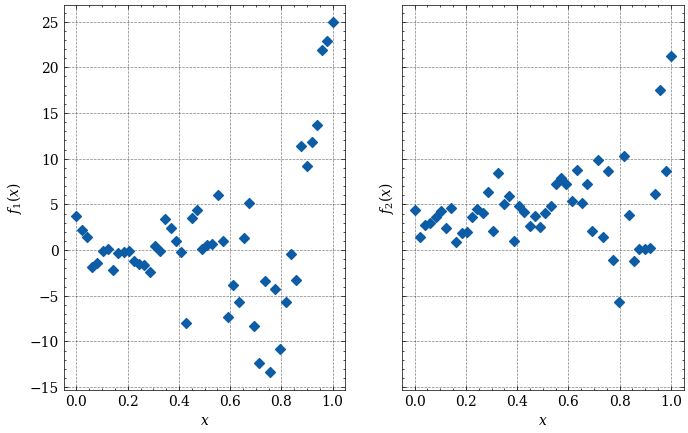

In [10]:
n = 50
# x = np.random.uniform(0, 1, n)
x = np.linspace(0, 1, n)

np.random.seed(20)
torch.manual_seed(20)

noise = 3
f = forrester2008(x, noisy=True, noiseconst=noise)

x = torch.tensor(x).unsqueeze(1)
f = torch.tensor(f)

fig, ax = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
for j in [0, 1]:
#     ax[j].plot(x0, f0[j], lw=2, alpha=0.2, color='gray')
    ax[j].scatter(x, f[j], marker='D', s=25, label=noise)
    ax[j].set_ylabel('$f_{:d}(x)$'.format(j+1))
    ax[j].set_xlabel('$x$')
# plt.legend(title='noise multiplier')

## 2D function for illustration comes from Forrester et al. (2008) (with modification)

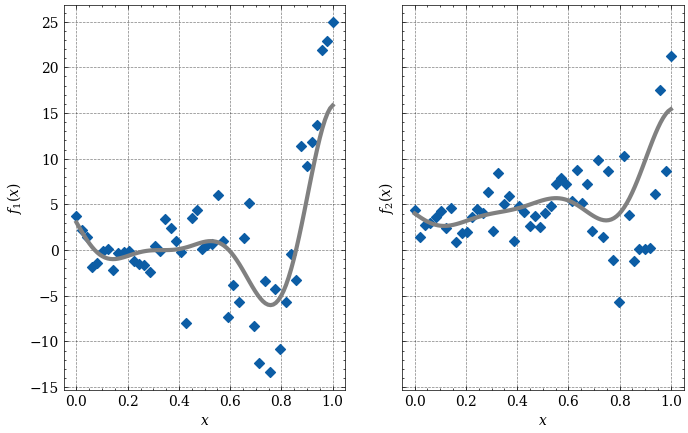

In [11]:
n0 = 100
x0 = np.linspace(0, 1, n0)

f0 = forrester2008(x0, noisy=False, noiseconst=0)

x0 = torch.tensor(x0).unsqueeze(1)
f0 = torch.tensor(f0)

fig, ax = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
for j in [0, 1]:
    ax[j].plot(x0, f0[j], lw=3, color='gray')
    ax[j].scatter(x, f[j], marker='x', color='k', s=25, label=noise)
    ax[j].set_ylabel('$f_{:d}(x)$'.format(j+1))
    ax[j].set_xlabel('$x$')
# plt.legend(title='noise multiplier')

## What if I just build a (Principal Component) GP over the data?

- A quick reminder of what the model looks like:
$$ f(x) = \Phi g(x) + \epsilon,  \quad \epsilon \sim N(0, \sigma^2) $$

$$ g_k(x) \sim \mathsf{GP}(0, c(\cdot, \cdot)) $$

- Arrange the data into an $n \times p$ matrix:
$$ F = (f(x_1)^T, \ldots, f(x_n)^T)^T $$

- Projection to an $n \times \kappa, \kappa \ll p$ matrix via $\Phi$:
$$ G = F \Phi $$

- Use each column $G_k$ to train a GP.

In [12]:
from test_general import test_single

emu, emumean, emustd, emupcto, \
        n, xtr, ftr, xte, fte = test_single(method='surmise', n=n, seed=0, noiseconst=noise,
                                            ftr=f, xtr=x, fte=f0, xte=x0,
                                            fte0=f0, output_csv=False, dir="",
                                            return_quant=True)


C:\Users\moses\Desktop\git\binary-hd-emulator\venv\lib\site-packages\surmise\emulation.py:168: UserWarning: Function supplementtheta not found in module!
  warnings.warn('Function supplementtheta not found in module!')


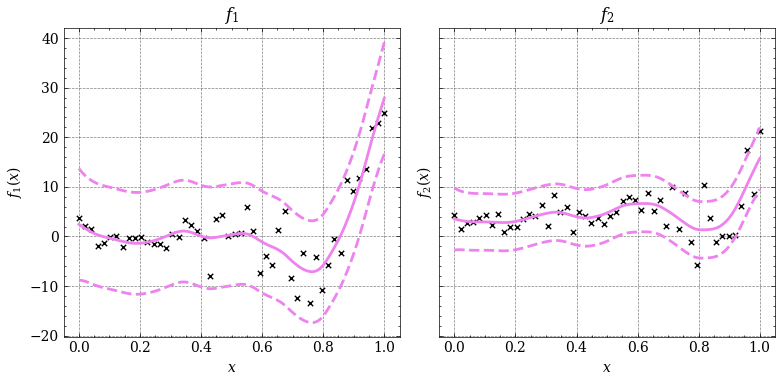

In [27]:
# 95 % confidence interval
emuub = (emumean + 2 * emustd)
emulb = (emumean - 2 * emustd)

# PCGP plots
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey='all')
axes[0].scatter(x=xtr, y=ftr[0], color='k', marker='x', s=15, label='Data')
axes[0].plot(xte, emumean[0].T, label='GP', color='violet', linewidth=2)
axes[0].plot(xte, emuub[0].T, label='GP', color='violet', linestyle='--', linewidth=2)
axes[0].plot(xte, emulb[0].T, label='GP', color='violet', linestyle='--', linewidth=2)
axes[0].set_xlabel(r'$x$')
axes[0].set_ylabel(r'$f_1(x)$')
axes[0].set_title('$f_1$')

axes[1].scatter(x=xtr, y=ftr[1], color='k', marker='x', s=15, label='Data')
axes[1].plot(xte, emumean[1].T, label='GP', color='violet', linewidth=2)
axes[1].plot(xte, emuub[1].T, label='GP', color='violet', linestyle='--', linewidth=2)
axes[1].plot(xte, emulb[1].T, label='GP', color='violet', linestyle='--', linewidth=2)
axes[1].set_xlabel(r'$x$')
axes[1].set_ylabel(r'$f_2(x)$')
axes[1].set_title('$f_2$')

plt.tight_layout()


### Here I am trying a mysterious model

In [23]:
model, predmean, confstd, Phi, \
        _, _, _, _, _ = test_single(method='MVGP', n=n, kap=1, seed=0, noiseconst=noise,
                                    ftr=f, xtr=x, fte=f0, xte=x0,
                                    fte0=f0, output_csv=False, dir="",
                                    return_quant=True)

#PCs: 1, recovery mse: 1.187E+01
exit after maximum epoch 101


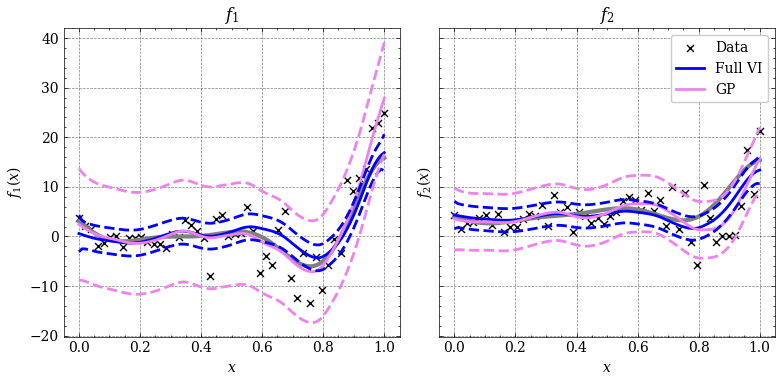

In [32]:
predstd = np.sqrt(confstd ** 2 + model.lsigma2.exp().item())
F_s = model.tx_F((model.Phi * model.pcw) @ model.M) 

predub = (predmean + 2 * predstd)
predlb = (predmean - 2 * predstd)
emuub = (emumean + 2 * emustd)
emulb = (emumean - 2 * emustd)

# With VIGP
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey='all')
axes[0].scatter(x=xtr, y=ftr[0], color='k', marker='x', s=25, label='Data')
# axes[0].scatter(x=xtr, y=F_s[0], color='r', marker='D', s=25, label='Smoothed data')
axes[0].plot(x0, f0[0], color='gray', lw=3)
axes[0].plot(xte, predmean[0].T, label='Full VI', color='b', linewidth=2)
axes[0].plot(xte, emumean[0].T, label='GP', color='violet', linewidth=2)
axes[0].plot(xte, predub[0].T, label='Full VI', color='b', linestyle='--', linewidth=2)
axes[0].plot(xte, emuub[0].T, label='GP', color='violet', linestyle='--', linewidth=2)
axes[0].plot(xte, predlb[0].T, label='Full VI', color='b', linestyle='--', linewidth=2)
axes[0].plot(xte, emulb[0].T, label='GP', color='violet', linestyle='--', linewidth=2)
axes[0].set_xlabel(r'$x$')
axes[0].set_ylabel(r'$f_1(x)$')
axes[0].set_title('$f_1$')

axes[1].scatter(x=xtr, y=ftr[1], color='k', marker='x', s=25, label='Data')
# axes[1].scatter(x=xtr, y=F_s[1], color='r', marker='D', s=25, label='Smoothed data')
axes[1].plot(x0, f0[1], color='gray', lw=3)
axes[1].plot(xte, predmean[1].T, label='Full VI', color='b', linewidth=2)
axes[1].plot(xte, emumean[1].T, label='GP', color='violet', linewidth=2)
axes[1].plot(xte, predub[1].T, label='Full VI', color='b', linestyle='--', linewidth=2)
axes[1].plot(xte, emuub[1].T, label='GP', color='violet', linestyle='--', linewidth=2)
axes[1].plot(xte, predlb[1].T, label='Full VI', color='b', linestyle='--', linewidth=2)
axes[1].plot(xte, emulb[1].T, label='GP', color='violet', linestyle='--', linewidth=2)
axes[1].set_xlabel(r'$x$')
axes[1].set_ylabel(r'$f_2(x)$')
axes[1].set_title('$f_2$')

handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
plt.legend(newHandles, newLabels)
plt.tight_layout()

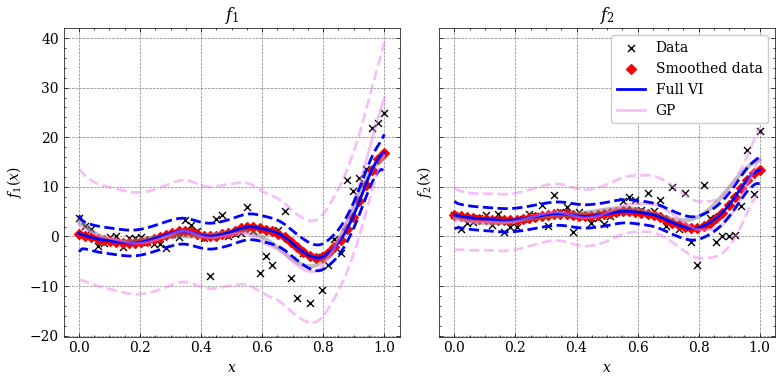

In [31]:
predstd = np.sqrt(confstd ** 2 + model.lsigma2.exp().item())
F_s = model.tx_F((model.Phi * model.pcw) @ model.M) 

predub = (predmean + 2 * predstd)
predlb = (predmean - 2 * predstd)
emuub = (emumean + 2 * emustd)
emulb = (emumean - 2 * emustd)

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey='all')
axes[0].scatter(x=xtr, y=ftr[0], color='k', marker='x', s=25, label='Data')
axes[0].scatter(x=xtr, y=F_s[0], color='r', marker='D', s=25, label='Smoothed data')
axes[0].plot(x0, f0[0], color='gray', lw=3, alpha=0.5)
axes[0].plot(xte, predmean[0].T, label='Full VI', color='b', linewidth=2)
axes[0].plot(xte, emumean[0].T, label='GP', color='violet', linewidth=2, alpha=0.5)
axes[0].plot(xte, predub[0].T, label='Full VI', color='b', linestyle='--', linewidth=2)
axes[0].plot(xte, emuub[0].T, label='GP', color='violet', linestyle='--', linewidth=2, alpha=0.5)
axes[0].plot(xte, predlb[0].T, label='Full VI', color='b', linestyle='--', linewidth=2)
axes[0].plot(xte, emulb[0].T, label='GP', color='violet', linestyle='--', linewidth=2, alpha=0.5)
axes[0].set_xlabel(r'$x$')
axes[0].set_ylabel(r'$f_1(x)$')
axes[0].set_title('$f_1$')

axes[1].scatter(x=xtr, y=ftr[1], color='k', marker='x', s=25, label='Data')
axes[1].scatter(x=xtr, y=F_s[1], color='r', marker='D', s=25, label='Smoothed data')
axes[1].plot(x0, f0[1], color='gray', lw=3, alpha=0.5)
axes[1].plot(xte, predmean[1].T, label='Full VI', color='b', linewidth=2)
axes[1].plot(xte, emumean[1].T, label='GP', color='violet', linewidth=2, alpha=0.5)
axes[1].plot(xte, predub[1].T, label='Full VI', color='b', linestyle='--', linewidth=2)
axes[1].plot(xte, emuub[1].T, label='GP', color='violet', linestyle='--', linewidth=2, alpha=0.5)
axes[1].plot(xte, predlb[1].T, label='Full VI', color='b', linestyle='--', linewidth=2)
axes[1].plot(xte, emulb[1].T, label='GP', color='violet', linestyle='--', linewidth=2, alpha=0.5)
axes[1].set_xlabel(r'$x$')
axes[1].set_ylabel(r'$f_2(x)$')
axes[1].set_title('$f_2$')

handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
plt.legend(newHandles, newLabels)
plt.tight_layout()

### Where do the smooth dots come from?